In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import figure, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc("xtick", labelsize=10, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=10, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes",grid=True,linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid",ls=":",lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=10) #Font og fontstørrelse
plt.rc("figure",figsize=(10,3),dpi=150) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major",width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major",width=1.3) #Sætter tykkelsen på xticks

In [108]:
brass_paths_tab = glob.glob("/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_*tab.lis")
brass_paths_tab.sort()
brass_paths = glob.glob("/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_*sum.lis")
brass_paths.sort()
tungsten_paths = glob.glob("/home/msd/AU/fluka_simulations/Full_Sim/Tungsten/tungsten_totsim_*sum.lis")
tungsten_paths.sort()

cool_times_dict = {
    "cool1": 300, "cool2": 900, "cool3": 3600, "cool4": 7200, "cool5": 14400, "cool6": 28800, "cool7": 57600, "cool8": 86400, 
    "cool9": 115200, "cool10": 259200, "cool11": 450, "cool12": 1400, "cool13": 2500, "cool14": 5400, "cool15": 10800,
    "cool16": 360000, "cool17": 21600, "cool18": 43200, "cool19": 150, "cool20": 600, "cool30": 0
}

In [122]:
def get_df_tab(path: str) -> [pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(path)
    cool_time = cool_times_dict[df.iloc[0, 0].replace(" ", "")]
    vals = df.loc[df[df.columns[0]].str.contains("#")].index.values
    df_isotopes = df.iloc[vals[0]+1:vals[1], 0].str.split(expand = True).astype(float)
    df_isomer = df.iloc[vals[1]+1:, 0].str.split(expand = True).astype(float)
    df_isotopes.columns = ["A", "Z", "Bq", "dBq"]
    df_isotopes.columns.name = cool_time
    df_isomer.columns = ["A", "Z", "m", "Bq", "dBq"]
    df_isomer.columns.name = cool_time
    return df_isotopes, df_isomer

def get_df_sum(path: str, extra = False) -> [pd.DataFrame, pd.DataFrame]:
    skipper = 18
    if extra:
        skipper = 194
    df = pd.read_csv(path, skiprows=skipper)
    vals = df.loc[df[df.columns[0]].str.contains("A")].index.values
    for i in range(len(vals)-1):
        if vals[i+1]-vals[i] <= 1:
            continue
        columns = df.iloc[vals[i], 0].split()[3:]
        dff = df.iloc[vals[i]+1:vals[i+1], 0].str.split(expand = True).reset_index().drop("index", axis=1)
        try:
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        except ValueError:
            dff = dff.drop(dff.tail(1).index)
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        ff.columns = columns
        dd = df.iloc[vals[i]+1:vals[i+1], 0]
        dd = dd.str.replace("+", "", regex=True)
        dd = dd.str.replace("/", "", regex=True)
        dd = dd.str.replace("-", "", regex=True)
        dd = dd.str.replace("%", "", regex=True)
        dd = dd.str.split(expand = True).reset_index().drop("index", axis=1)
        dg = dd.loc[1::2,:len(columns)-1].astype(float)
        dg.columns = columns
        dg.index = ff.index
        if i == 0:
            tot_df = ff
            tot_df_d = dg
        else:
            tot_df = pd.concat([tot_df, ff])
            tot_df_d = pd.concat([tot_df_d, dg])
    name = cool_times_dict[f"cool{int(path.split('_')[4])-20}"]
    tot_df_d.columns.name = name
    tot_df.columns.name = name
    return tot_df, tot_df_d
    
        
    
def plot_img(df: pd.DataFrame, pivot: bool, transpose = False) -> None:
    plt.figure(figsize=(7, 5))
    plt.title(f"Cooling time in sec = {df.columns.name}")
    ax = plt.gca()
    if pivot:
        data = df.pivot_table(index='Z', columns='A', values='Bq')
    else:
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value = df.index[-1]
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value2 = df.index[-1]
        aa = pd.DataFrame(index=range(last_value+1), columns =range(last_value2+1))
        aa.iloc[df.columns.values, df.index.values] = df.transpose().values
        data = aa.fillna(0)
    if transpose:
        data = data.transpose()
    im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=0.1, vmax=10000), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    return 


def find_elements(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[df[i] > threshold, i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    return df_return.sort_values("Z")


In [131]:
ff1, ff2 = get_df_sum(tungsten_paths[15])
print("Cooling time =", ff1.columns.name/60/60, "Hours")
find_elements(ff1, 40)

Cooling time = 100.0 Hours


,A,Z,Bq
66,3,1,429000.0
64,7,4,4760000.0
65,14,6,6580.0
61,35,16,2890.0
62,39,18,115.0
...,...,...,...
35,182,75,3610000.0
34,183,75,21200000.0
32,186,75,579000.0
36,181,75,1540000.0


In [98]:
ff1, ff2 = get_df_sum(brass_paths[15])
print("Cooling time =", ff1.columns.name/60/60, "Hours")
find_elements(ff1, 4000000)

Cooling time = 100.0 Hours


,A,Z,Bq
3,7,4,4870000.0
0,58,27,14400000.0
1,57,27,6180000.0
2,65,30,10600000.0


In [106]:
ff1, ff2 = get_df_sum(brass_paths[18])
print("Cooling time =", ff1.columns.name/60, "min")
find_elements(ff1, 4000000)

Cooling time = 2.5 min


,A,Z,Bq
12,7,4,5150000.0
13,11,6,16800000.0
14,15,8,22800000.0
1,58,27,15000000.0
2,57,27,6240000.0
3,64,29,34500000.0
4,62,29,73400000.0
5,61,29,40400000.0
6,60,29,5700000.0
7,65,30,10700000.0


In [105]:
ff1, ff2 = get_df_sum(tungsten_paths[18])
print("Cooling time =", ff1.columns.name/60, "min")
find_elements(ff1, 4000000)

Cooling time = 2.5 min


,A,Z,Bq
24,7,4,5030000.0
25,11,6,16600000.0
26,15,8,22600000.0
0,175,72,10900000.0
4,175,73,13100000.0
5,174,73,4690000.0
1,179,73,13300000.0
3,176,73,25400000.0
2,177,73,44400000.0
12,176,74,23800000.0


In [20]:
times_brass = []
tungsten_t = []
sums_brass = []
tunsten_sums = []

for paths, t_path in zip(brass_paths, tungsten_paths):
    try:
        times_brass.append(cool_times_dict[f"cool{int(paths.split('_')[4])-20}"])
        ff1, uncb = get_df_sum(paths)
        sums_brass.append(ff1.sum().sum())
    except:
        print(paths)
    try:
        tungsten_t.append(cool_times_dict[f"cool{int(t_path.split('_')[4])-20}"])
        ft1, unct = get_df_sum(t_path)
        tunsten_sums.append(ft1.sum().sum())
    except:
        print(t_path)


/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_50_sum.lis
/home/msd/AU/fluka_simulations/Full_Sim/Tungsten/tungsten_totsim_50_sum.lis


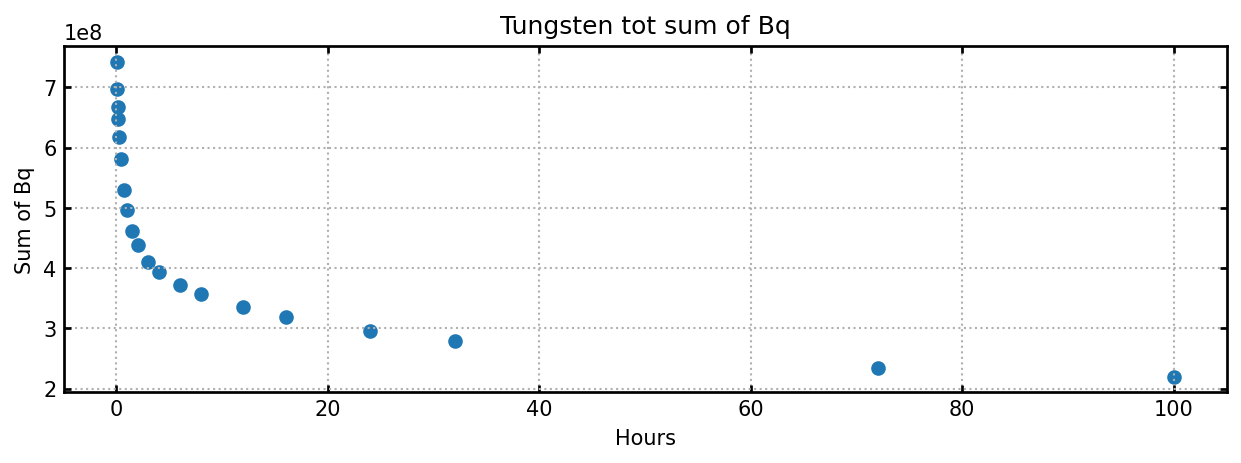

In [21]:
plt.scatter(np.array(tungsten_t)/60/60, tunsten_sums)
plt.title("Tungsten tot sum of Bq")
plt.xlabel("Hours")
plt.ylabel("Sum of Bq")
plt.show()

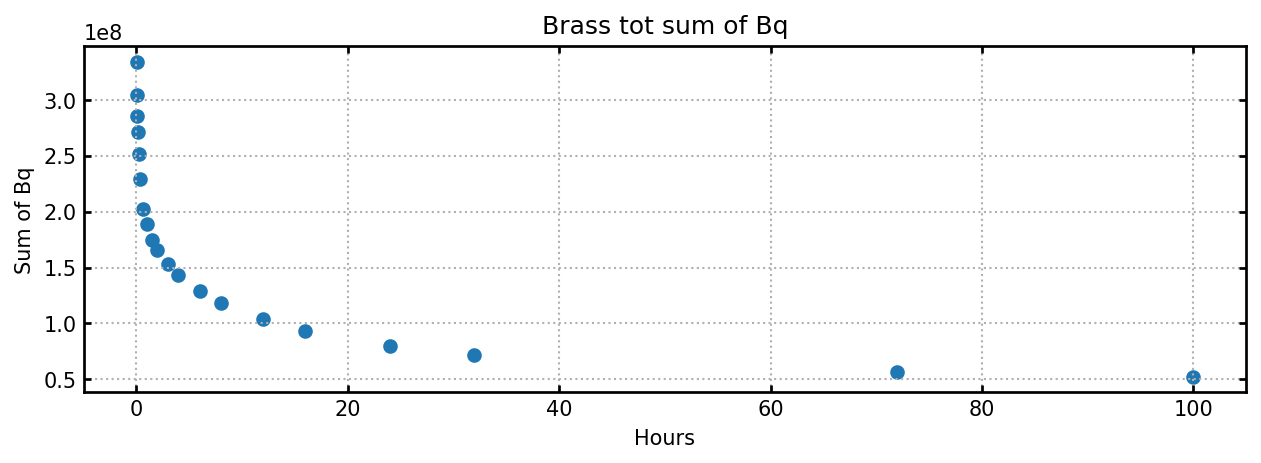

In [22]:
plt.scatter(np.array(times_brass)/60/60, sums_brass)
plt.title("Brass tot sum of Bq")
plt.xlabel("Hours")
plt.ylabel("Sum of Bq")
plt.show()

In [7]:
df1, df2 = get_df_tab(brass_paths_tab[0])

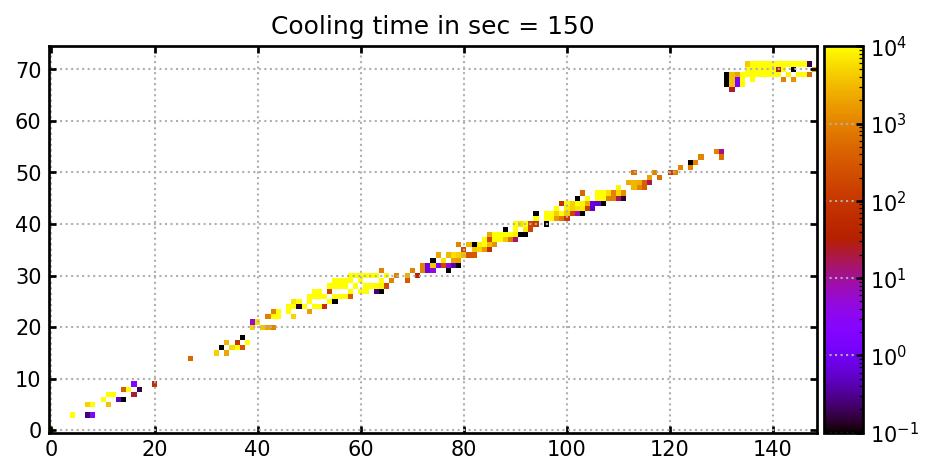

In [8]:
plot_img(df1, True) # not correct dunno what this tab thing is started with it and discovered that it did not work

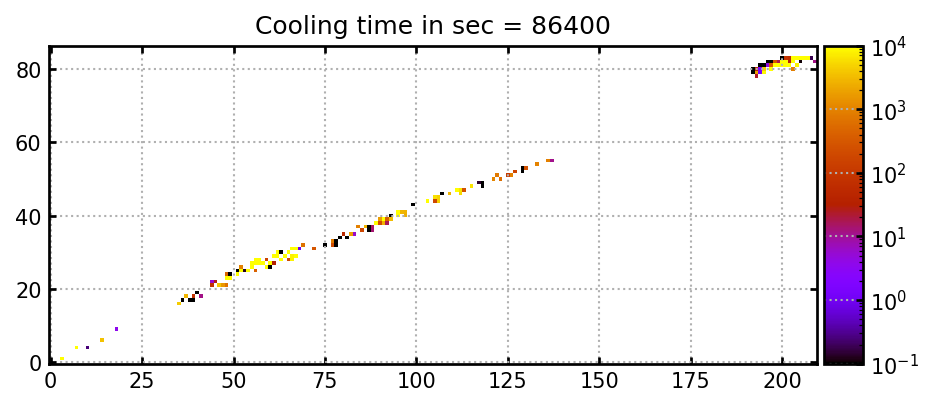

In [9]:
ff1, ff2 = get_df_sum(brass_paths[4])
plot_img(ff1, False, True)

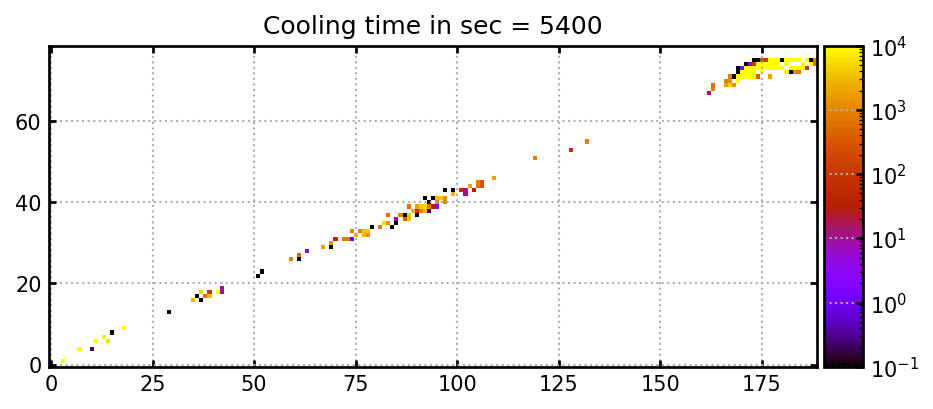

In [23]:
ff1, ff2 = get_df_sum(tungsten_paths[4])
plot_img(ff1, False, True)

In [24]:
ff1

5400,68,69,70,71,72,73,74,75,76,77,...,4,5,6,7,8,9,10,11,12,1
0,,,,,,,,,,,,,,,,,,,,,
188,0.0,0.0,0.0,0.0,0.0,0.0,821.0,8.200000e+02,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,0.0,0.0,0.0,0.0,0.0,0.0,23400000.0,1.850000e-04,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,0.0,0.0,0.0,0.0,0.0,121.0,0.0,1.240000e+06,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,0.0,0.0,0.0,0.0,0.0,230000.0,24400000.0,0.000000e+00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,0.0,0.0,0.0,0.0,777.0,495000.0,0.0,1.190000e+07,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.0,0.0,7090.0,0.0,0.0,0.0,0.0,0.0,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.0,846000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [35]:
ff1.loc[ff1["68"] > 4000, "68"].values

array([], dtype=float64)